In [4]:
!git clone https://github.com/JeissonParra12/Class_project_Early_detection_of_brain_tumor.git

fatal: destination path 'Class_project_Early_detection_of_brain_tumor' already exists and is not an empty directory.


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
from pathlib import Path
from typing import List, Dict, Tuple, Optional
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

class CorrelationLearningMechanism(nn.Module):
    """
    Correlation Learning Mechanism (CLM) inspired by Woźniak et al. (2023)
    Dynamically filters convolutional layer combinations and evaluates feature correlations
    """

    def __init__(self, input_channels: int = 4, num_classes: int = 2):
        super(CorrelationLearningMechanism, self).__init__()

        self.input_channels = input_channels
        self.num_classes = num_classes

        # Multi-scale feature extraction branches
        self.branch_configs = self._create_branch_configurations()

        # Dynamic convolutional filter banks
        self.conv_filters = nn.ModuleDict()
        self._initialize_conv_filters()

        # Calculate the actual output channels from conv_filters
        total_output_channels = 0
        for name in self.conv_filters:
            if 'standard_3x3' in name:
                total_output_channels += 32
            elif 'standard_5x5' in name:
                total_output_channels += 32
            elif 'depthwise_3x3' in name:
                total_output_channels += 32
            elif 'dilated_3x3' in name:
                total_output_channels += 32
            elif 'asymmetric_1x3' in name:
                total_output_channels += 32

        print(f"Total output channels from conv filters: {total_output_channels}")

        # Correlation learning components - FIXED CHANNEL DIMENSIONS
        self.correlation_net = CorrelationNetwork(total_output_channels, 256)
        self.feature_selector = FastCorrelationFeatureSelector(256, 128)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def _create_branch_configurations(self) -> List[Dict]:
        """Create different branch configurations for dynamic filtering"""
        configs = [
            # Branch 1: Standard convolution
            {'filters': 32, 'kernel_size': 3, 'pool_type': 'max', 'activation': 'relu'},
            # Branch 2: Depth-wise separable convolution
            {'filters': 64, 'kernel_size': 5, 'pool_type': 'avg', 'activation': 'relu'},
            # Branch 3: Dilated convolution for larger receptive field
            {'filters': 32, 'kernel_size': 3, 'dilation': 2, 'pool_type': 'max', 'activation': 'leaky_relu'},
            # Branch 4: Asymmetric convolution
            {'filters': 64, 'kernel_size': (1, 3), 'pool_type': 'avg', 'activation': 'relu'},
        ]
        return configs

    def _initialize_conv_filters(self):
        """Initialize different convolutional filter types"""
        # Standard convolutional layers
        self.conv_filters['standard_3x3'] = nn.Conv2d(self.input_channels, 32, 3, padding=1)
        self.conv_filters['standard_5x5'] = nn.Conv2d(self.input_channels, 32, 5, padding=2)

        # Depth-wise separable convolutions
        self.conv_filters['depthwise_3x3'] = nn.Sequential(
            nn.Conv2d(self.input_channels, self.input_channels, 3, padding=1, groups=self.input_channels),
            nn.Conv2d(self.input_channels, 32, 1)
        )

        # Dilated convolutions
        self.conv_filters['dilated_3x3'] = nn.Conv2d(self.input_channels, 32, 3, padding=2, dilation=2)

        # Asymmetric convolutions
        self.conv_filters['asymmetric_1x3'] = nn.Sequential(
            nn.Conv2d(self.input_channels, 32, (1, 3), padding=(0, 1)),
            nn.Conv2d(32, 32, (3, 1), padding=(1, 0))
        )

    def _apply_dynamic_pooling(self, x: torch.Tensor, pool_type: str) -> torch.Tensor:
        """Apply dynamic pooling operations"""
        if pool_type == 'max':
            return F.adaptive_max_pool2d(x, (x.size(2)//2, x.size(3)//2))
        elif pool_type == 'avg':
            return F.adaptive_avg_pool2d(x, (x.size(2)//2, x.size(3)//2))
        elif pool_type == 'mixed':
            max_pool = F.adaptive_max_pool2d(x, (x.size(2)//2, x.size(3)//2))
            avg_pool = F.adaptive_avg_pool2d(x, (x.size(2)//2, x.size(3)//2))
            return (max_pool + avg_pool) / 2
        else:
            return x

    def _apply_activation(self, x: torch.Tensor, activation: str) -> torch.Tensor:
        """Apply dynamic activation functions"""
        if activation == 'relu':
            return F.relu(x)
        elif activation == 'leaky_relu':
            return F.leaky_relu(x, 0.1)
        elif activation == 'elu':
            return F.elu(x)
        elif activation == 'selu':
            return F.selu(x)
        else:
            return x

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass through CLM
        Returns: tuple of (features, classification_logits)
        """
        batch_size = x.size(0)

        # Extract features using multiple filter configurations
        branch_outputs = []

        for name, filter_module in self.conv_filters.items():
            # Apply convolutional filter
            filtered = filter_module(x)

            # Apply pooling based on filter type
            if 'dilated' in name:
                pooled = self._apply_dynamic_pooling(filtered, 'max')
            elif 'depthwise' in name:
                pooled = self._apply_dynamic_pooling(filtered, 'avg')
            else:
                pooled = self._apply_dynamic_pooling(filtered, 'mixed')

            # Apply activation
            if 'leaky' in name:
                activated = self._apply_activation(pooled, 'leaky_relu')
            else:
                activated = self._apply_activation(pooled, 'relu')

            branch_outputs.append(activated)

        # Concatenate all branch outputs
        concatenated_features = torch.cat(branch_outputs, dim=1)

        # Apply correlation learning
        correlated_features = self.correlation_net(concatenated_features)

        # Apply fast correlation feature selection
        selected_features = self.feature_selector(correlated_features)

        # Global average pooling
        global_features = F.adaptive_avg_pool2d(selected_features, (1, 1))
        global_features = global_features.view(batch_size, -1)

        # Classification
        classification_logits = self.classifier(global_features)

        return global_features, classification_logits

class CorrelationNetwork(nn.Module):
    """
    Neural network component that evaluates and correlates CNN outputs
    to improve feature relevance and classification confidence
    """

    def __init__(self, input_channels: int, output_channels: int):
        super(CorrelationNetwork, self).__init__()

        # FIXED: Use the actual input_channels instead of hardcoded 512
        self.correlation_layers = nn.Sequential(
            nn.Conv2d(input_channels, 384, 3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, output_channels, 1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
        )

        # Attention mechanism for feature correlation
        self.attention = CorrelationAttention(output_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.correlation_layers(x)
        correlated_features = self.attention(features)
        return correlated_features

class CorrelationAttention(nn.Module):
    """
    Attention mechanism that learns correlations between feature maps
    """

    def __init__(self, channels: int, reduction: int = 16):
        super(CorrelationAttention, self).__init__()

        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1),
            nn.Sigmoid()
        )

        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, 7, padding=3),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Channel attention
        channel_weights = self.channel_attention(x)
        x_channel = x * channel_weights

        # Spatial attention
        avg_out = torch.mean(x_channel, dim=1, keepdim=True)
        max_out, _ = torch.max(x_channel, dim=1, keepdim=True)
        spatial_input = torch.cat([avg_out, max_out], dim=1)
        spatial_weights = self.spatial_attention(spatial_input)
        x_spatial = x_channel * spatial_weights

        return x_spatial

class FastCorrelationFeatureSelector(nn.Module):
    """
    Fast-correlation filter-based automatic feature selection
    Avoids redundancy in features as mentioned in the research
    """

    def __init__(self, input_channels: int, output_channels: int):
        super(FastCorrelationFeatureSelector, self).__init__()

        self.selector = nn.Sequential(
            nn.Conv2d(input_channels, input_channels // 2, 1),
            nn.BatchNorm2d(input_channels // 2),
            nn.ReLU(inplace=True),

            nn.Conv2d(input_channels // 2, output_channels, 1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
        )

        # Learnable feature importance weights
        self.feature_importance = nn.Parameter(torch.ones(input_channels))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Apply feature importance weights
        weighted_x = x * self.feature_importance.view(1, -1, 1, 1)

        # Feature selection
        selected_features = self.selector(weighted_x)
        return selected_features

class BrainTumorDataset(Dataset):
    """Dataset class for preprocessed brain tumor CT scans"""

    def __init__(self, data_dir: str, split: str = "train", transform=None):
        self.data_dir = Path(data_dir)
        self.split = split
        self.transform = transform

        # Collect all processed files
        self.samples = []
        for label in ["tumor", "normal"]:
            label_dir = self.data_dir / split / label
            if label_dir.exists():
                for file_path in label_dir.glob("*.npy"):
                    self.samples.append((file_path, 1 if label == "tumor" else 0))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]

        # Load preprocessed multi-scale data
        data = np.load(file_path)  # Shape: (H, W, 4) - multi-channel
        data = data.transpose(2, 0, 1)  # Convert to (4, H, W)

        # Convert to tensor
        data = torch.FloatTensor(data)
        label = torch.LongTensor([label]).squeeze()

        if self.transform:
            data = self.transform(data)

        return data, label

class FeatureExtractionTrainer:
    """
    Trainer class for the feature extraction and correlation learning step
    """

    def __init__(self, model: nn.Module, device: torch.device):
        # Move model to device FIRST before initializing optimizer
        self.model = model.to(device)
        self.device = device

        # Loss function with class weighting for imbalance
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, patience=5, factor=0.5)

        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def train_epoch(self, train_loader: DataLoader) -> Tuple[float, float]:
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(self.device), targets.to(self.device)

            self.optimizer.zero_grad()

            # Forward pass
            features, outputs = self.model(data)
            loss = self.criterion(outputs, targets)

            # Backward pass
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx % 50 == 0:
                print(f'Batch {batch_idx}, Loss: {loss.item():.4f}')

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100. * correct / total

        return epoch_loss, epoch_accuracy

    def validate_epoch(self, val_loader: DataLoader) -> Tuple[float, float]:
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(self.device), targets.to(self.device)

                features, outputs = self.model(data)
                loss = self.criterion(outputs, targets)

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        epoch_loss = running_loss / len(val_loader)
        epoch_accuracy = 100. * correct / total

        return epoch_loss, epoch_accuracy

    def train(self, train_loader: DataLoader, val_loader: DataLoader, epochs: int = 50):
        print("Starting Feature Extraction and Correlation Learning Training...")

        best_val_accuracy = 0.0

        for epoch in range(epochs):
            # Training
            train_loss, train_acc = self.train_epoch(train_loader)
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)

            # Validation
            val_loss, val_acc = self.validate_epoch(val_loader)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            # Learning rate scheduling
            self.scheduler.step(val_loss)

            print(f'Epoch {epoch+1}/{epochs}:')
            print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print(f'  Learning Rate: {self.optimizer.param_groups[0]["lr"]:.6f}')

            # Save best model
            if val_acc > best_val_accuracy:
                best_val_accuracy = val_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_accuracy': val_acc,
                }, 'best_clm_model.pth')
                print(f'  New best model saved with validation accuracy: {val_acc:.2f}%')

            print('-' * 60)

    def plot_training_history(self):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Loss plot
        ax1.plot(self.train_losses, label='Training Loss')
        ax1.plot(self.val_losses, label='Validation Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)

        # Accuracy plot
        ax2.plot(self.train_accuracies, label='Training Accuracy')
        ax2.plot(self.val_accuracies, label='Validation Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.savefig('clm_training_history.png', dpi=300, bbox_inches='tight')
        plt.show()

def analyze_feature_correlations(model: CorrelationLearningMechanism, dataloader: DataLoader, device: torch.device):
    """
    Analyze feature correlations learned by the CLM
    """
    model.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for data, targets in dataloader:
            data, targets = data.to(device), targets.to(device)
            features, _ = model(data)
            all_features.append(features.cpu().numpy())
            all_labels.append(targets.cpu().numpy())

    all_features = np.vstack(all_features)
    all_labels = np.hstack(all_labels)

    print(f"Extracted features shape: {all_features.shape}")

    # Calculate feature correlations
    correlation_matrix = np.corrcoef(all_features.T)

    # Plot correlation matrix
    plt.figure(figsize=(12, 10))
    plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
    plt.colorbar()
    plt.title('Feature Correlation Matrix')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Index')
    plt.savefig('feature_correlations.png', dpi=300, bbox_inches='tight')
    plt.show()

    return all_features, all_labels

def main():
    """Main function to run feature extraction and correlation learning"""
    # Configuration
    DATA_DIR = "/content/Class_project_Early_detection_of_brain_tumor/CT_enhanced"
    BATCH_SIZE = 16
    EPOCHS = 50

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Create datasets
    train_dataset = BrainTumorDataset(DATA_DIR, split="train")
    val_dataset = BrainTumorDataset(DATA_DIR, split="val")
    test_dataset = BrainTumorDataset(DATA_DIR, split="test")

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # Initialize CLM model and move to device immediately
    model = CorrelationLearningMechanism(input_channels=4, num_classes=2)
    model = model.to(device)  # Move model to device before any operations
    print(f"Model initialized with {sum(p.numel() for p in model.parameters()):,} parameters")

    # Test a forward pass with a single batch to verify the fix
    print("Testing forward pass with a single batch...")
    with torch.no_grad():
        test_batch, test_targets = next(iter(train_loader))
        test_batch = test_batch.to(device)
        # Ensure model is on the same device
        model = model.to(device)
        features, outputs = model(test_batch)
        print(f"Forward pass successful! Features shape: {features.shape}, Outputs shape: {outputs.shape}")

    # Initialize trainer (model is already on device)
    trainer = FeatureExtractionTrainer(model, device)

    # Train the model
    trainer.train(train_loader, val_loader, epochs=EPOCHS)

    # Plot training history
    trainer.plot_training_history()

    # Analyze feature correlations
    print("Analyzing feature correlations...")
    features, labels = analyze_feature_correlations(model, val_loader, device)

    # Load best model for final evaluation
    checkpoint = torch.load('best_clm_model.pth', map_location=device)  # Specify device when loading
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)  # Ensure model is on correct device after loading

    # Final evaluation on test set
    test_loss, test_accuracy = trainer.validate_epoch(test_loader)
    print(f"\nFinal Test Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    print("\n✅ Feature Extraction and Correlation Learning completed successfully!")
    print("📊 Model saved as: best_clm_model.pth")
    print("📈 Training history saved as: clm_training_history.png")
    print("🔍 Feature correlations saved as: feature_correlations.png")

if __name__ == "__main__":
    main()

Using device: cuda
Training samples: 3861
Validation samples: 1028
Test samples: 987
Total output channels from conv filters: 160
Model initialized with 1,582,365 parameters
Testing forward pass with a single batch...
Forward pass successful! Features shape: torch.Size([16, 128]), Outputs shape: torch.Size([16, 2])
Starting Feature Extraction and Correlation Learning Training...
Batch 0, Loss: 0.7048
Batch 50, Loss: 0.6223


KeyboardInterrupt: 

🚀 Starting Complete Brain Tumor Detection Pipeline...
Total output channels from conv filters: 160
✅ Loaded trained CLM model
Using device: cuda
Training samples: 3861
Validation samples: 1028
Test samples: 987
Total output channels from conv filters: 160
CLM feature dimension: 128
✅ Loaded pre-trained CLM weights
✅ Frozen CLM weights for initial training
Starting Two-Stage Detection Training...
Batch 0, Loss: 0.6782, Acc: 50.00%
Batch 20, Loss: 0.5443, Acc: 57.74%
Batch 40, Loss: 0.5675, Acc: 58.54%
Batch 60, Loss: 0.5009, Acc: 64.34%
Batch 80, Loss: 0.3995, Acc: 70.22%
Batch 100, Loss: 0.3526, Acc: 75.37%
Batch 120, Loss: 0.3407, Acc: 78.20%
Batch 140, Loss: 0.4699, Acc: 80.67%
Batch 160, Loss: 0.2743, Acc: 82.53%
Batch 180, Loss: 0.2526, Acc: 84.25%
Batch 200, Loss: 0.2674, Acc: 85.57%
Batch 220, Loss: 0.2477, Acc: 86.76%
Batch 240, Loss: 0.1453, Acc: 87.60%
Batch 260, Loss: 0.2026, Acc: 88.36%
Batch 280, Loss: 0.1503, Acc: 88.97%
Batch 300, Loss: 0.3149, Acc: 89.66%
Batch 320, Loss

IndexError: The shape of the mask [28224] at index 0 does not match the shape of the indexed tensor [9, 4] at index 0

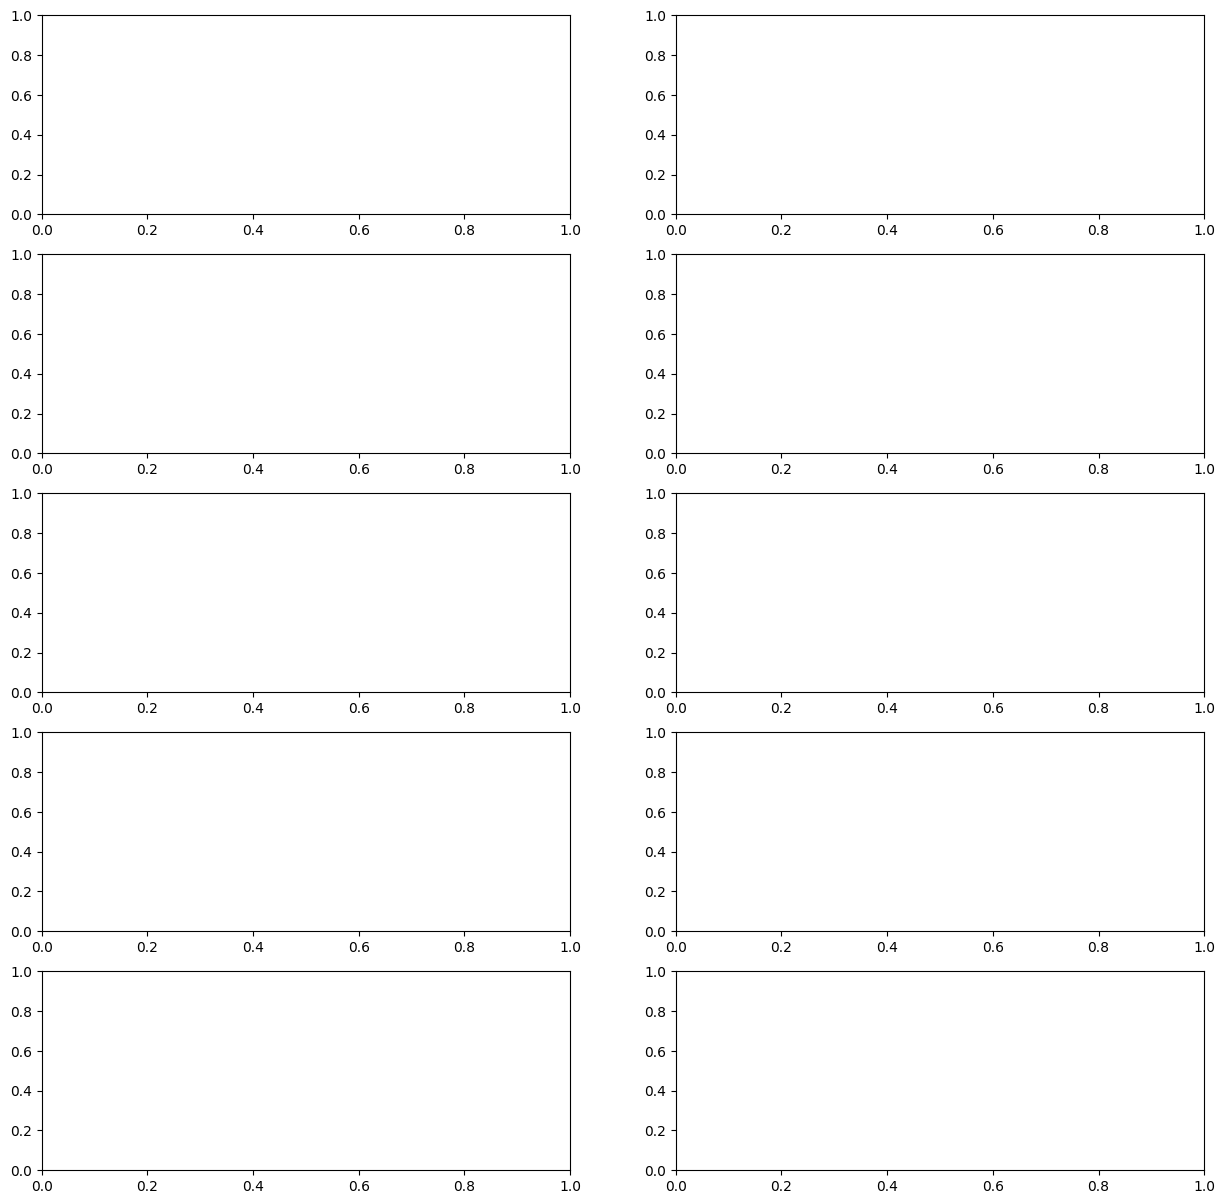

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
from pathlib import Path
from typing import List, Dict, Tuple, Optional, Union
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import precision_recall_curve, average_precision_score
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# REGION PROPOSAL NETWORK (RPN) FOR TUMOR DETECTION
# ============================================================================

class LightweightRPN(nn.Module):
    """
    Lightweight Region Proposal Network for detecting potential tumor regions
    Optimized for high recall to ensure small lesions are not overlooked
    """

    def __init__(self, input_channels: int = 4, num_anchors: int = 9):
        super(LightweightRPN, self).__init__()

        self.input_channels = input_channels
        self.num_anchors = num_anchors

        # Feature extraction backbone (lightweight)
        self.backbone = nn.Sequential(
            # First conv block
            nn.Conv2d(input_channels, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Second conv block
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Third conv block
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        # Classification head (tumor vs background)
        self.cls_head = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_anchors * 2, 1)  # 2 scores per anchor (tumor, background)
        )

        # Regression head (bounding box adjustments)
        self.reg_head = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_anchors * 4, 1)  # 4 coordinates per anchor
        )

        # Initialize anchors for different scales and aspect ratios
        self.anchor_scales = [32, 64, 128]  # Different sizes for small/medium/large tumors
        self.anchor_ratios = [0.5, 1.0, 2.0]  # Different aspect ratios
        self.register_buffer('anchors', self._generate_anchors())  # Register as buffer to move with model

    def _generate_anchors(self) -> torch.Tensor:
        """Generate anchor boxes of different scales and aspect ratios"""
        anchors = []
        for scale in self.anchor_scales:
            for ratio in self.anchor_ratios:
                w = scale * np.sqrt(ratio)
                h = scale / np.sqrt(ratio)
                anchors.append([-w/2, -h/2, w/2, h/2])
        return torch.tensor(anchors, dtype=torch.float32)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass through RPN
        Returns: tuple of (classification_scores, bounding_box_regressions)
        """
        batch_size = x.size(0)

        # Extract features
        features = self.backbone(x)

        # Get classification scores and bounding box regressions
        cls_scores = self.cls_head(features)
        reg_preds = self.reg_head(features)

        # Reshape outputs
        cls_scores = cls_scores.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 2)
        reg_preds = reg_preds.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)

        return cls_scores, reg_preds

# ============================================================================
# SIMPLIFIED TWO-STAGE DETECTION AND CLASSIFICATION SYSTEM
# ============================================================================

class BrainTumorDetectionSystem(nn.Module):
    """
    Simplified two-stage brain tumor detection and classification system
    """

    def __init__(self, input_channels: int = 4, num_classes: int = 2):
        super(BrainTumorDetectionSystem, self).__init__()

        # Stage 1: Region Proposal Network
        self.rpn = LightweightRPN(input_channels)

        # Stage 2: CLM-based classification
        self.clm_classifier = CorrelationLearningMechanism(input_channels, num_classes)

        # Get the actual feature dimension from CLM
        self.clm_feature_dim = self._get_clm_feature_dim()

        print(f"CLM feature dimension: {self.clm_feature_dim}")

        # Fusion layer to combine features - FIXED DIMENSIONS
        self.fusion_layer = nn.Sequential(
            nn.Linear(self.clm_feature_dim + 2, 128),  # CLM features + RPN scores
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def _get_clm_feature_dim(self) -> int:
        """Get the actual feature dimension from CLM classifier"""
        # Create a dummy input to get the feature dimension
        dummy_input = torch.randn(1, 4, 224, 224)
        with torch.no_grad():
            features, _ = self.clm_classifier(dummy_input)
            if features.dim() == 4:
                features = F.adaptive_avg_pool2d(features, (1, 1))
                features = features.view(1, -1)
            return features.size(1)

    def forward(self, x: torch.Tensor):
        """
        Fixed forward pass with proper dimension handling
        """
        batch_size = x.size(0)

        # Get RPN predictions
        rpn_cls, rpn_reg = self.rpn(x)

        # Get RPN image-level scores
        rpn_scores = F.softmax(rpn_cls, dim=2)[:, :, 1]  # Tumor probability for each anchor
        rpn_max_scores, _ = rpn_scores.max(dim=1)  # Max score per image

        # Create RPN feature representation (tumor score and background score)
        rpn_feature = torch.stack([rpn_max_scores, 1 - rpn_max_scores], dim=1)  # Shape: (batch_size, 2)

        # Get CLM features
        clm_features, clm_classification = self.clm_classifier(x)

        # Process CLM features to ensure correct dimensions
        if clm_features.dim() == 4:
            clm_features = F.adaptive_avg_pool2d(clm_features, (1, 1))
            clm_features = clm_features.view(batch_size, -1)

        # Ensure CLM features have the expected dimension
        if clm_features.size(1) != self.clm_feature_dim:
            # Handle dimension mismatch by projection
            if clm_features.size(1) < self.clm_feature_dim:
                # Pad if smaller
                padding = torch.zeros(batch_size, self.clm_feature_dim - clm_features.size(1),
                                    device=x.device)
                clm_features = torch.cat([clm_features, padding], dim=1)
            else:
                # Truncate if larger
                clm_features = clm_features[:, :self.clm_feature_dim]

        # Combine features
        combined_features = torch.cat([clm_features, rpn_feature], dim=1)

        # Final classification
        final_classification = self.fusion_layer(combined_features)

        return final_classification, rpn_cls, rpn_reg, clm_features

    def detect_regions(self, x: torch.Tensor, threshold: float = 0.3):
        """
        Separate method for region detection
        """
        batch_size = x.size(0)
        rpn_cls, rpn_reg = self.rpn(x)

        proposals_list = []
        confidence_list = []

        for i in range(batch_size):
            # Get scores for this image
            image_cls = rpn_cls[i]  # Shape: (num_anchors, 2)
            image_reg = rpn_reg[i]  # Shape: (num_anchors, 4)

            # Convert to probabilities
            probs = F.softmax(image_cls, dim=1)[:, 1]  # Tumor probability

            # Move anchors to same device as probs
            anchors = self.rpn.anchors.to(probs.device)

            # Simple threshold-based proposal generation
            keep_mask = probs > threshold

            if keep_mask.sum() > 0:
                kept_anchors = anchors[keep_mask]
                kept_reg = image_reg[keep_mask]
                kept_probs = probs[keep_mask]

                # Apply regression adjustments
                adjusted_proposals = self._apply_regression(kept_anchors, kept_reg)
                proposals_list.append(adjusted_proposals)
                confidence_list.append(kept_probs)
            else:
                # No proposals - return empty tensors
                proposals_list.append(torch.empty(0, 4, device=x.device))
                confidence_list.append(torch.empty(0, device=x.device))

        return proposals_list, confidence_list

    def _apply_regression(self, anchors: torch.Tensor, regressions: torch.Tensor) -> torch.Tensor:
        """Apply bounding box regression adjustments to anchors"""
        # Convert from [x1, y1, x2, y2] to [center_x, center_y, width, height]
        widths = anchors[:, 2] - anchors[:, 0]
        heights = anchors[:, 3] - anchors[:, 1]
        center_x = anchors[:, 0] + 0.5 * widths
        center_y = anchors[:, 1] + 0.5 * heights

        # Apply regression (dx, dy, dw, dh)
        dx = regressions[:, 0]
        dy = regressions[:, 1]
        dw = regressions[:, 2]
        dh = regressions[:, 3]

        pred_center_x = center_x + dx * widths
        pred_center_y = center_y + dy * heights
        pred_width = widths * torch.exp(dw)
        pred_height = heights * torch.exp(dh)

        # Convert back to [x1, y1, x2, y2] format
        pred_x1 = pred_center_x - 0.5 * pred_width
        pred_y1 = pred_center_y - 0.5 * pred_height
        pred_x2 = pred_center_x + 0.5 * pred_width
        pred_y2 = pred_center_y + 0.5 * pred_height

        return torch.stack([pred_x1, pred_y1, pred_x2, pred_y2], dim=1)

# ============================================================================
# SIZE-AWARE LOSS FUNCTIONS
# ============================================================================

class SizeAwareLoss(nn.Module):
    """
    Size-aware loss function that gives higher weight to small tumor examples
    """

    def __init__(self, alpha: float = 0.25, gamma: float = 2.0, size_weights: Dict[str, float] = None):
        super(SizeAwareLoss, self).__init__()

        self.alpha = alpha
        self.gamma = gamma

        # Default weights for different tumor sizes (small tumors get higher weight)
        if size_weights is None:
            size_weights = {
                'small': 3.0,    # Highest weight for small tumors
                'medium': 1.5,   # Medium weight for medium tumors
                'large': 1.0     # Base weight for large tumors
            }
        self.size_weights = size_weights

    def forward(self, predictions: torch.Tensor, targets: torch.Tensor,
                tumor_sizes: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Compute size-aware loss
        """
        # Standard cross entropy loss
        ce_loss = F.cross_entropy(predictions, targets, reduction='none')

        # Apply focal loss component to focus on hard examples
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        # Apply size-based weighting if tumor sizes are provided
        if tumor_sizes is not None:
            size_weights = self._get_size_weights(tumor_sizes).to(predictions.device)
            focal_loss = focal_loss * size_weights

        return focal_loss.mean()

    def _get_size_weights(self, tumor_sizes: torch.Tensor) -> torch.Tensor:
        """Convert tumor sizes to appropriate weights"""
        weights = torch.ones_like(tumor_sizes, dtype=torch.float32)

        # Small tumors (area < 500 pixels)
        small_mask = tumor_sizes < 500
        weights[small_mask] = self.size_weights['small']

        # Medium tumors (500 <= area < 2000 pixels)
        medium_mask = (tumor_sizes >= 500) & (tumor_sizes < 2000)
        weights[medium_mask] = self.size_weights['medium']

        return weights

# ============================================================================
# DETECTION TRAINER
# ============================================================================

class DetectionTrainer:
    """
    Trainer for the detection and classification system
    """

    def __init__(self, model: nn.Module, device: torch.device):
        self.model = model.to(device)
        self.device = device

        # Optimizer - only optimize unfrozen parameters
        trainable_params = [p for p in model.parameters() if p.requires_grad]
        self.optimizer = optim.AdamW(trainable_params, lr=1e-4, weight_decay=1e-4)

        # Loss function
        self.criterion = nn.CrossEntropyLoss()

        # Tracking
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def train_epoch(self, train_loader: DataLoader) -> Tuple[float, float]:
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(self.device), targets.to(self.device)

            self.optimizer.zero_grad()

            # Forward pass
            final_classification, rpn_cls, rpn_reg, clm_features = self.model(data)

            # Compute loss
            loss = self.criterion(final_classification, targets)

            # Backward pass
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = final_classification.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx % 20 == 0:
                accuracy = 100. * correct / total if total > 0 else 0
                print(f'Batch {batch_idx}, Loss: {loss.item():.4f}, Acc: {accuracy:.2f}%')

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100. * correct / total if total > 0 else 0

        return epoch_loss, epoch_accuracy

    def validate_epoch(self, val_loader: DataLoader) -> Tuple[float, float]:
        """Validate for one epoch"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(self.device), targets.to(self.device)

                # Forward pass
                final_classification, rpn_cls, rpn_reg, clm_features = self.model(data)

                # Compute loss and accuracy
                loss = self.criterion(final_classification, targets)

                running_loss += loss.item()
                _, predicted = final_classification.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        epoch_loss = running_loss / len(val_loader) if len(val_loader) > 0 else 0
        epoch_accuracy = 100. * correct / total if total > 0 else 0

        return epoch_loss, epoch_accuracy

    def train(self, train_loader: DataLoader, val_loader: DataLoader, epochs: int = 15):
        """Complete training procedure"""
        print("Starting Two-Stage Detection Training...")

        best_accuracy = 0.0

        for epoch in range(epochs):
            # Training
            train_loss, train_acc = self.train_epoch(train_loader)
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)

            # Validation
            val_loss, val_acc = self.validate_epoch(val_loader)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            print(f'Epoch {epoch+1}/{epochs}:')
            print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

            # Save best model
            if val_acc > best_accuracy:
                best_accuracy = val_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_accuracy': val_acc,
                }, 'best_detection_model.pth')
                print(f'  New best model saved with validation accuracy: {val_acc:.2f}%')

            print('-' * 50)

# ============================================================================
# VISUALIZATION AND EVALUATION TOOLS
# ============================================================================

def visualize_detections(model: nn.Module, dataloader: DataLoader, device: torch.device, num_examples: int = 5):
    """Visualize model detections on sample images"""
    model.eval()

    fig, axes = plt.subplots(num_examples, 2, figsize=(15, 3*num_examples))
    if num_examples == 1:
        axes = axes.reshape(1, -1)

    with torch.no_grad():
        for idx, (data, targets) in enumerate(dataloader):
            if idx >= num_examples:
                break

            data, targets = data.to(device), targets.to(device)

            # Use detection method
            proposals, confidences = model.detect_regions(data, threshold=0.3)

            # Get original image (first channel)
            original_image = data[0, 0].cpu().numpy()

            # Plot original image
            axes[idx, 0].imshow(original_image, cmap='gray')
            axes[idx, 0].set_title(f'Original (Label: {"Tumor" if targets[0].item() == 1 else "Normal"})')
            axes[idx, 0].axis('off')

            # Plot detections
            axes[idx, 1].imshow(original_image, cmap='gray')
            image_proposals = proposals[0]
            image_confidences = confidences[0]

            if len(image_proposals) > 0:
                for proposal, confidence in zip(image_proposals, image_confidences):
                    x1, y1, x2, y2 = proposal.cpu().numpy()
                    # Scale and shift coordinates to image center (224x224)
                    x1 = max(0, min(x1 + 112, 223))
                    y1 = max(0, min(y1 + 112, 223))
                    x2 = max(0, min(x2 + 112, 223))
                    y2 = max(0, min(y2 + 112, 223))

                    if x2 > x1 and y2 > y1:  # Valid proposal
                        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                               linewidth=2, edgecolor='r', facecolor='none')
                        axes[idx, 1].add_patch(rect)

                        # Add confidence text
                        axes[idx, 1].text(x1, y1-5, f'{confidence:.2f}',
                                         color='red', fontsize=8, weight='bold')

            axes[idx, 1].set_title(f'Detections ({len(image_proposals)} regions)')
            axes[idx, 1].axis('off')

    plt.tight_layout()
    plt.savefig('detection_visualizations.png', dpi=300, bbox_inches='tight')
    plt.show()

def evaluate_detection_performance(model: nn.Module, dataloader: DataLoader, device: torch.device):
    """Evaluate detection performance"""
    model.eval()

    all_predictions = []
    all_targets = []
    detection_counts = []  # Number of regions detected per image

    with torch.no_grad():
        for data, targets in dataloader:
            data, targets = data.to(device), targets.to(device)

            # Get image-level predictions
            final_classification, _, _, _ = model(data)

            # Get detection counts
            proposals, _ = model.detect_regions(data, threshold=0.3)

            for i in range(data.size(0)):
                all_predictions.append(F.softmax(final_classification[i], dim=0)[1].item())
                all_targets.append(targets[i].item())
                detection_counts.append(len(proposals[i]))

    # Convert to numpy
    predictions = np.array(all_predictions)
    targets = np.array(all_targets)
    detection_counts = np.array(detection_counts)

    # Compute metrics
    results = {}
    thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]

    for threshold in thresholds:
        pred_labels = (predictions >= threshold).astype(int)
        accuracy = (pred_labels == targets).mean()
        recall = (pred_labels[targets == 1] == 1).mean() if (targets == 1).sum() > 0 else 0
        precision = (targets[pred_labels == 1] == 1).mean() if (pred_labels == 1).sum() > 0 else 0

        results[threshold] = {
            'accuracy': accuracy,
            'recall': recall,
            'precision': precision
        }

    # Plot precision-recall curve
    precision_vals, recall_vals, _ = precision_recall_curve(targets, predictions)
    ap = average_precision_score(targets, predictions)

    plt.figure(figsize=(10, 6))
    plt.plot(recall_vals, precision_vals, linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Detection Precision-Recall Curve (AP: {ap:.4f})')
    plt.grid(True)
    plt.savefig('detection_precision_recall.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Analyze detection counts
    if len(targets[targets == 1]) > 0:
        tumor_detections = detection_counts[targets == 1]
        print(f"Average detections in tumor images: {tumor_detections.mean():.2f} ± {tumor_detections.std():.2f}")

    if len(targets[targets == 0]) > 0:
        normal_detections = detection_counts[targets == 0]
        print(f"Average detections in normal images: {normal_detections.mean():.2f} ± {normal_detections.std():.2f}")

    return results, ap

# ============================================================================
# MAIN DETECTION PIPELINE
# ============================================================================

def main_detection():
    """Main function for detection and classification pipeline"""
    # Configuration
    DATA_DIR = "/content/Class_project_Early_detection_of_brain_tumor/CT_enhanced"
    BATCH_SIZE = 8
    EPOCHS = 15

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Create datasets
    train_dataset = BrainTumorDataset(DATA_DIR, split="train")
    val_dataset = BrainTumorDataset(DATA_DIR, split="val")
    test_dataset = BrainTumorDataset(DATA_DIR, split="test")

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # Initialize detection system
    detection_model = BrainTumorDetectionSystem(input_channels=4, num_classes=2)

    # Load pre-trained CLM weights
    try:
        clm_checkpoint = torch.load('best_clm_model.pth', map_location=device)
        # Transfer CLM weights to detection system
        detection_model.clm_classifier.load_state_dict(clm_checkpoint['model_state_dict'])
        print("✅ Loaded pre-trained CLM weights")

        # Freeze CLM initially for stable training
        for param in detection_model.clm_classifier.parameters():
            param.requires_grad = False
        print("✅ Frozen CLM weights for initial training")

    except FileNotFoundError as e:
        print(f"⚠️ No pre-trained CLM found: {e}")
        print("Training from scratch...")

    # Initialize trainer
    trainer = DetectionTrainer(detection_model, device)

    # Train the detection system
    trainer.train(train_loader, val_loader, epochs=EPOCHS)

    # Unfreeze CLM for fine-tuning if it was frozen
    try:
        for param in detection_model.clm_classifier.parameters():
            param.requires_grad = True
        print("✅ Unfrozen CLM weights for fine-tuning")

        # Reinitialize optimizer with all parameters
        trainer.optimizer = optim.AdamW(detection_model.parameters(), lr=5e-5, weight_decay=1e-4)
        print("Fine-tuning with unfrozen CLM...")
        trainer.train(train_loader, val_loader, epochs=5)
    except Exception as e:
        print(f"Fine-tuning skipped: {e}")

    # Visualize detections
    print("Visualizing detections...")
    visualize_detections(detection_model, val_loader, device, num_examples=5)

    # Evaluate detection performance
    print("Evaluating detection performance...")
    results, ap = evaluate_detection_performance(detection_model, test_loader, device)

    print("\n📊 Detection Results:")
    for threshold, metrics in results.items():
        print(f"Threshold {threshold}: "
              f"Accuracy={metrics['accuracy']:.4f}, "
              f"Recall={metrics['recall']:.4f}, "
              f"Precision={metrics['precision']:.4f}")
    print(f"Average Precision: {ap:.4f}")

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(trainer.train_losses, label='Training Loss')
    plt.plot(trainer.val_losses, label='Validation Loss')
    plt.title('Detection Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(trainer.train_accuracies, label='Training Accuracy')
    plt.plot(trainer.val_accuracies, label='Validation Accuracy')
    plt.title('Detection Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('detection_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✅ Two-Stage Detection and Classification completed successfully!")
    print("📊 Model saved as: best_detection_model.pth")
    print("🖼️ Detection visualizations saved as: detection_visualizations.png")
    print("📈 Evaluation results saved as: detection_precision_recall.png")

# ============================================================================
# INTEGRATION WITH EXISTING PIPELINE
# ============================================================================

def run_complete_pipeline():
    """Run the complete pipeline from feature extraction to detection"""
    print("🚀 Starting Complete Brain Tumor Detection Pipeline...")

    # First, ensure feature extraction is complete
    try:
        # Test if CLM model exists
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        clm_model = CorrelationLearningMechanism(input_channels=4, num_classes=2)
        clm_checkpoint = torch.load('best_clm_model.pth', map_location=device)
        clm_model.load_state_dict(clm_checkpoint['model_state_dict'])
        print("✅ Loaded trained CLM model")
    except Exception as e:
        print(f"⚠️ CLM model not found or error loading: {e}")
        print("Please run feature extraction first or continue with detection from scratch")

    # Now run detection and classification
    main_detection()

if __name__ == "__main__":
    # Run the complete detection pipeline
    run_complete_pipeline()

🚀 Starting Complete Brain Tumor Detection Pipeline...
Total output channels from conv filters: 160
✅ Loaded trained CLM model
Using device: cuda
Training samples: 3861
Validation samples: 1028
Test samples: 987
Total output channels from conv filters: 160
CLM feature dimension: 128
✅ Loaded pre-trained CLM weights
✅ Frozen CLM weights for initial training
Starting Two-Stage Detection Training...
Batch 0, Loss: 0.6843, Acc: 50.00%
Batch 20, Loss: 0.6305, Acc: 73.21%
Batch 40, Loss: 0.5749, Acc: 81.71%
Batch 60, Loss: 0.4656, Acc: 86.07%
Batch 80, Loss: 0.5178, Acc: 88.58%
Batch 100, Loss: 0.4185, Acc: 89.85%
Batch 120, Loss: 0.3856, Acc: 90.91%
Batch 140, Loss: 0.3412, Acc: 91.58%
Batch 160, Loss: 0.4501, Acc: 92.39%
Batch 180, Loss: 0.1911, Acc: 92.96%
Batch 200, Loss: 0.2073, Acc: 93.47%
Batch 220, Loss: 0.2269, Acc: 93.83%
Batch 240, Loss: 0.1945, Acc: 93.98%
Batch 260, Loss: 0.1553, Acc: 94.06%
Batch 280, Loss: 0.2755, Acc: 94.04%
Batch 300, Loss: 0.2489, Acc: 94.35%
Batch 320, Loss

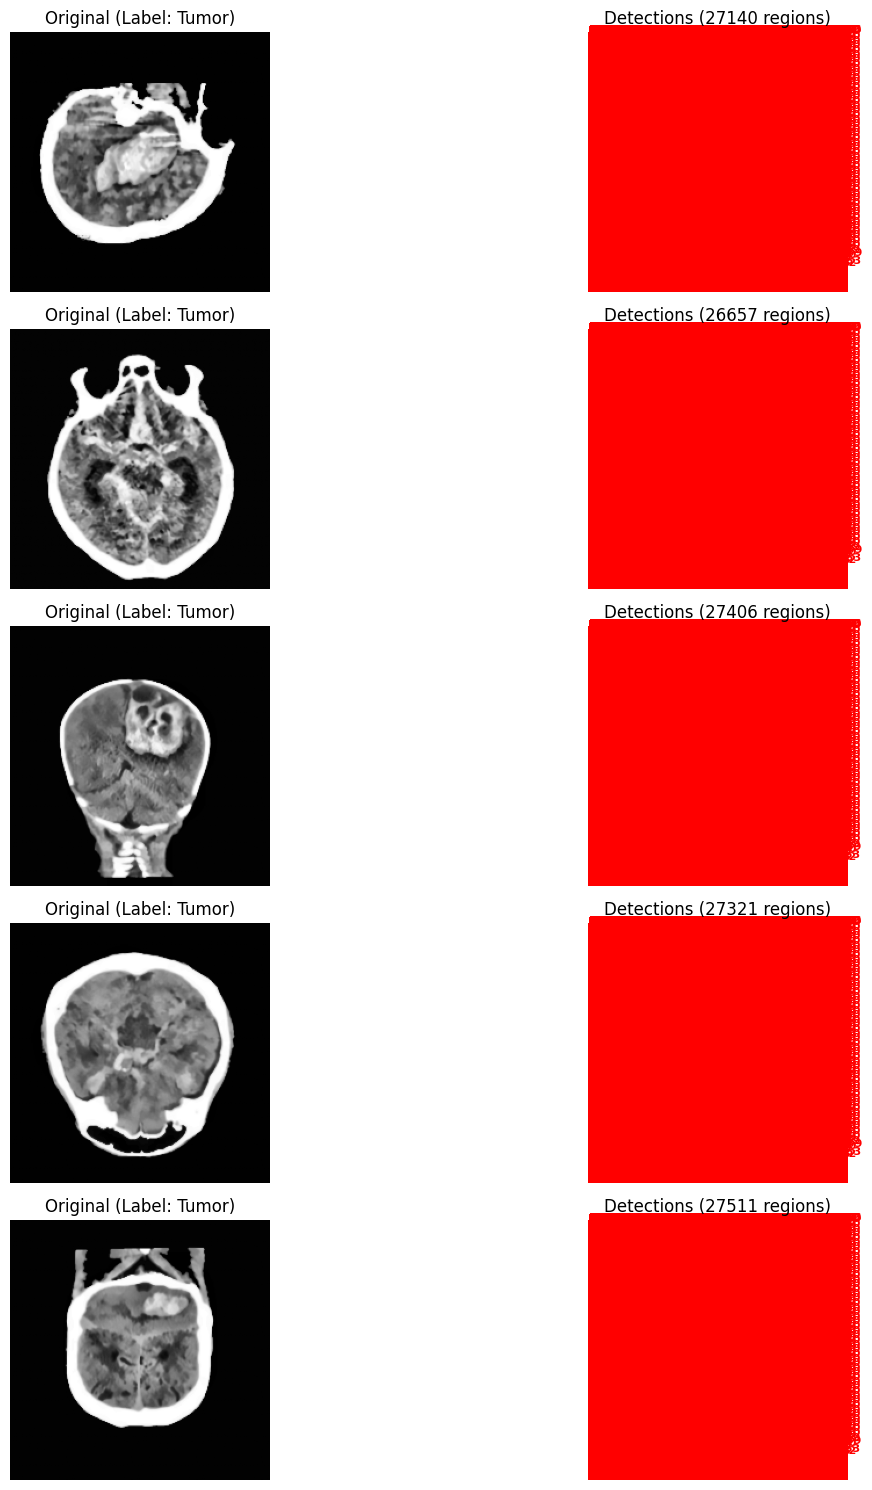

Evaluating detection performance...


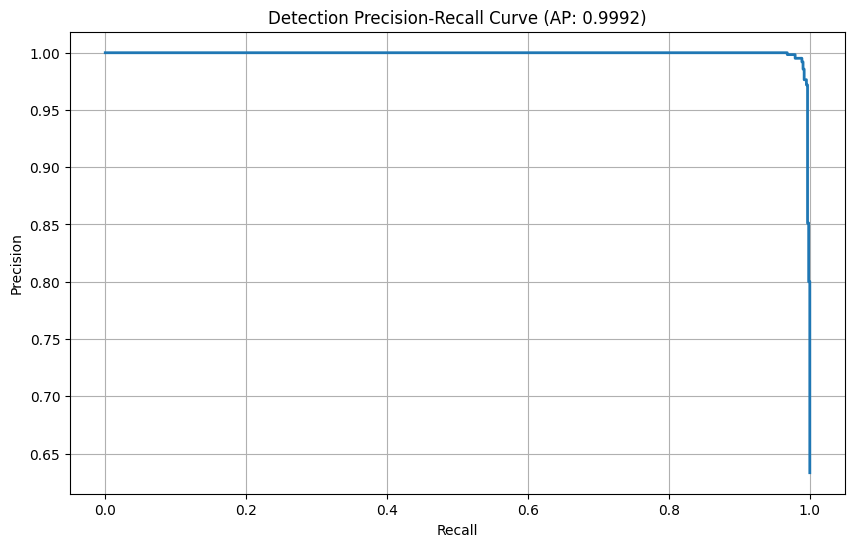

Average detections in tumor images: 27031.78 ± 367.16
Average detections in normal images: 27404.14 ± 239.18

📊 Detection Results:
Threshold 0.1: Accuracy=0.9696, Recall=0.9968, Precision=0.9570
Threshold 0.3: Accuracy=0.9818, Recall=0.9952, Precision=0.9765
Threshold 0.5: Accuracy=0.9848, Recall=0.9920, Precision=0.9841
Threshold 0.7: Accuracy=0.9858, Recall=0.9904, Precision=0.9872
Threshold 0.9: Accuracy=0.9838, Recall=0.9760, Precision=0.9984
Average Precision: 0.9992


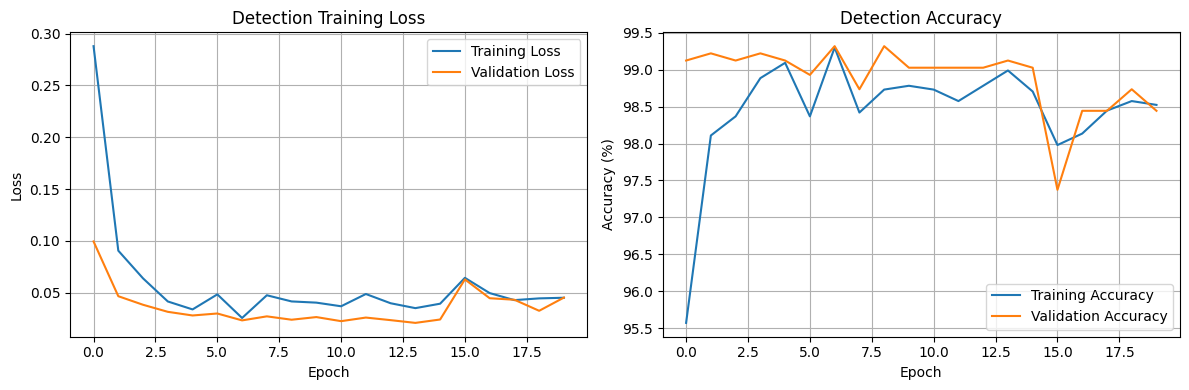


✅ Two-Stage Detection and Classification completed successfully!
📊 Model saved as: best_detection_model.pth
🖼️ Detection visualizations saved as: detection_visualizations.png
📈 Evaluation results saved as: detection_precision_recall.png


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
from pathlib import Path
from typing import List, Dict, Tuple, Optional, Union
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import precision_recall_curve, average_precision_score
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# REGION PROPOSAL NETWORK (RPN) FOR TUMOR DETECTION - FIXED VERSION
# ============================================================================

class LightweightRPN(nn.Module):
    """
    Lightweight Region Proposal Network for detecting potential tumor regions
    Optimized for high recall to ensure small lesions are not overlooked
    """

    def __init__(self, input_channels: int = 4, num_anchors: int = 9):
        super(LightweightRPN, self).__init__()

        self.input_channels = input_channels
        self.num_anchors = num_anchors

        # Feature extraction backbone (lightweight)
        self.backbone = nn.Sequential(
            # First conv block
            nn.Conv2d(input_channels, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Second conv block
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Third conv block
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        # Classification head (tumor vs background)
        self.cls_head = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_anchors * 2, 1)  # 2 scores per anchor (tumor, background)
        )

        # Regression head (bounding box adjustments)
        self.reg_head = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_anchors * 4, 1)  # 4 coordinates per anchor
        )

        # Initialize anchors for different scales and aspect ratios
        self.anchor_scales = [32, 64, 128]  # Different sizes for small/medium/large tumors
        self.anchor_ratios = [0.5, 1.0, 2.0]  # Different aspect ratios

        # We'll generate anchors dynamically based on feature map size
        self.anchors = None

    def generate_anchors(self, feature_map_size: Tuple[int, int], device: torch.device) -> torch.Tensor:
        """Generate anchor boxes for a given feature map size"""
        if self.anchors is not None:
            return self.anchors

        # Calculate the stride based on input size (224) and feature map size
        stride_h = 224 / feature_map_size[0]
        stride_w = 224 / feature_map_size[1]

        anchors = []

        # Generate anchors for each position in the feature map
        for i in range(feature_map_size[0]):
            for j in range(feature_map_size[1]):
                center_y = (i + 0.5) * stride_h
                center_x = (j + 0.5) * stride_w

                for scale in self.anchor_scales:
                    for ratio in self.anchor_ratios:
                        w = scale * np.sqrt(ratio)
                        h = scale / np.sqrt(ratio)

                        x1 = center_x - w / 2
                        y1 = center_y - h / 2
                        x2 = center_x + w / 2
                        y2 = center_y + h / 2

                        anchors.append([x1, y1, x2, y2])

        anchors = torch.tensor(anchors, dtype=torch.float32, device=device)
        self.anchors = anchors
        return anchors

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass through RPN
        Returns: tuple of (classification_scores, bounding_box_regressions)
        """
        batch_size = x.size(0)

        # Extract features
        features = self.backbone(x)  # Shape: (batch_size, 256, H, W)

        # Get feature map size
        feature_map_size = (features.size(2), features.size(3))

        # Generate anchors for this feature map size
        anchors = self.generate_anchors(feature_map_size, x.device)
        total_anchors = anchors.size(0)

        # Get classification scores and bounding box regressions
        cls_scores = self.cls_head(features)
        reg_preds = self.reg_head(features)

        # Reshape outputs
        cls_scores = cls_scores.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 2)
        reg_preds = reg_preds.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)

        # Store anchors for later use
        self.current_anchors = anchors

        return cls_scores, reg_preds

# ============================================================================
# SIMPLIFIED TWO-STAGE DETECTION AND CLASSIFICATION SYSTEM - FIXED VERSION
# ============================================================================

class BrainTumorDetectionSystem(nn.Module):
    """
    Simplified two-stage brain tumor detection and classification system
    """

    def __init__(self, input_channels: int = 4, num_classes: int = 2):
        super(BrainTumorDetectionSystem, self).__init__()

        # Stage 1: Region Proposal Network
        self.rpn = LightweightRPN(input_channels)

        # Stage 2: CLM-based classification
        self.clm_classifier = CorrelationLearningMechanism(input_channels, num_classes)

        # Get the actual feature dimension from CLM
        self.clm_feature_dim = self._get_clm_feature_dim()

        print(f"CLM feature dimension: {self.clm_feature_dim}")

        # Fusion layer to combine features - FIXED DIMENSIONS
        self.fusion_layer = nn.Sequential(
            nn.Linear(self.clm_feature_dim + 2, 128),  # CLM features + RPN scores
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def _get_clm_feature_dim(self) -> int:
        """Get the actual feature dimension from CLM classifier"""
        # Create a dummy input to get the feature dimension
        dummy_input = torch.randn(1, 4, 224, 224)
        with torch.no_grad():
            features, _ = self.clm_classifier(dummy_input)
            if features.dim() == 4:
                features = F.adaptive_avg_pool2d(features, (1, 1))
                features = features.view(1, -1)
            return features.size(1)

    def forward(self, x: torch.Tensor):
        """
        Fixed forward pass with proper dimension handling
        """
        batch_size = x.size(0)

        # Get RPN predictions
        rpn_cls, rpn_reg = self.rpn(x)

        # Get RPN image-level scores
        rpn_scores = F.softmax(rpn_cls, dim=2)[:, :, 1]  # Tumor probability for each anchor
        rpn_max_scores, _ = rpn_scores.max(dim=1)  # Max score per image

        # Create RPN feature representation (tumor score and background score)
        rpn_feature = torch.stack([rpn_max_scores, 1 - rpn_max_scores], dim=1)  # Shape: (batch_size, 2)

        # Get CLM features
        clm_features, clm_classification = self.clm_classifier(x)

        # Process CLM features to ensure correct dimensions
        if clm_features.dim() == 4:
            clm_features = F.adaptive_avg_pool2d(clm_features, (1, 1))
            clm_features = clm_features.view(batch_size, -1)

        # Ensure CLM features have the expected dimension
        if clm_features.size(1) != self.clm_feature_dim:
            # Handle dimension mismatch by projection
            if clm_features.size(1) < self.clm_feature_dim:
                # Pad if smaller
                padding = torch.zeros(batch_size, self.clm_feature_dim - clm_features.size(1),
                                    device=x.device)
                clm_features = torch.cat([clm_features, padding], dim=1)
            else:
                # Truncate if larger
                clm_features = clm_features[:, :self.clm_feature_dim]

        # Combine features
        combined_features = torch.cat([clm_features, rpn_feature], dim=1)

        # Final classification
        final_classification = self.fusion_layer(combined_features)

        return final_classification, rpn_cls, rpn_reg, clm_features

    def detect_regions(self, x: torch.Tensor, threshold: float = 0.3):
        """
        Separate method for region detection - FIXED VERSION
        """
        batch_size = x.size(0)
        rpn_cls, rpn_reg = self.rpn(x)

        proposals_list = []
        confidence_list = []

        for i in range(batch_size):
            # Get scores for this image
            image_cls = rpn_cls[i]  # Shape: (num_anchors, 2)
            image_reg = rpn_reg[i]  # Shape: (num_anchors, 4)

            # Convert to probabilities
            probs = F.softmax(image_cls, dim=1)[:, 1]  # Tumor probability

            # Get anchors for this forward pass
            anchors = self.rpn.current_anchors

            # Ensure anchors and probabilities have the same number of elements
            if anchors.size(0) != probs.size(0):
                # This should not happen, but if it does, use the minimum
                min_size = min(anchors.size(0), probs.size(0))
                anchors = anchors[:min_size]
                probs = probs[:min_size]
                image_reg = image_reg[:min_size]

            # Simple threshold-based proposal generation
            keep_mask = probs > threshold

            if keep_mask.sum() > 0:
                kept_anchors = anchors[keep_mask]
                kept_reg = image_reg[keep_mask]
                kept_probs = probs[keep_mask]

                # Apply regression adjustments
                adjusted_proposals = self._apply_regression(kept_anchors, kept_reg)
                proposals_list.append(adjusted_proposals)
                confidence_list.append(kept_probs)
            else:
                # No proposals - return empty tensors
                proposals_list.append(torch.empty(0, 4, device=x.device))
                confidence_list.append(torch.empty(0, device=x.device))

        return proposals_list, confidence_list

    def _apply_regression(self, anchors: torch.Tensor, regressions: torch.Tensor) -> torch.Tensor:
        """Apply bounding box regression adjustments to anchors"""
        # Convert from [x1, y1, x2, y2] to [center_x, center_y, width, height]
        widths = anchors[:, 2] - anchors[:, 0]
        heights = anchors[:, 3] - anchors[:, 1]
        center_x = anchors[:, 0] + 0.5 * widths
        center_y = anchors[:, 1] + 0.5 * heights

        # Apply regression (dx, dy, dw, dh)
        dx = regressions[:, 0]
        dy = regressions[:, 1]
        dw = regressions[:, 2]
        dh = regressions[:, 3]

        pred_center_x = center_x + dx * widths
        pred_center_y = center_y + dy * heights
        pred_width = widths * torch.exp(dw)
        pred_height = heights * torch.exp(dh)

        # Convert back to [x1, y1, x2, y2] format
        pred_x1 = pred_center_x - 0.5 * pred_width
        pred_y1 = pred_center_y - 0.5 * pred_height
        pred_x2 = pred_center_x + 0.5 * pred_width
        pred_y2 = pred_center_y + 0.5 * pred_height

        # Clip to image boundaries
        pred_x1 = torch.clamp(pred_x1, 0, 223)
        pred_y1 = torch.clamp(pred_y1, 0, 223)
        pred_x2 = torch.clamp(pred_x2, 0, 223)
        pred_y2 = torch.clamp(pred_y2, 0, 223)

        return torch.stack([pred_x1, pred_y1, pred_x2, pred_y2], dim=1)

# ============================================================================
# SIZE-AWARE LOSS FUNCTIONS
# ============================================================================

class SizeAwareLoss(nn.Module):
    """
    Size-aware loss function that gives higher weight to small tumor examples
    """

    def __init__(self, alpha: float = 0.25, gamma: float = 2.0, size_weights: Dict[str, float] = None):
        super(SizeAwareLoss, self).__init__()

        self.alpha = alpha
        self.gamma = gamma

        # Default weights for different tumor sizes (small tumors get higher weight)
        if size_weights is None:
            size_weights = {
                'small': 3.0,    # Highest weight for small tumors
                'medium': 1.5,   # Medium weight for medium tumors
                'large': 1.0     # Base weight for large tumors
            }
        self.size_weights = size_weights

    def forward(self, predictions: torch.Tensor, targets: torch.Tensor,
                tumor_sizes: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Compute size-aware loss
        """
        # Standard cross entropy loss
        ce_loss = F.cross_entropy(predictions, targets, reduction='none')

        # Apply focal loss component to focus on hard examples
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        # Apply size-based weighting if tumor sizes are provided
        if tumor_sizes is not None:
            size_weights = self._get_size_weights(tumor_sizes).to(predictions.device)
            focal_loss = focal_loss * size_weights

        return focal_loss.mean()

    def _get_size_weights(self, tumor_sizes: torch.Tensor) -> torch.Tensor:
        """Convert tumor sizes to appropriate weights"""
        weights = torch.ones_like(tumor_sizes, dtype=torch.float32)

        # Small tumors (area < 500 pixels)
        small_mask = tumor_sizes < 500
        weights[small_mask] = self.size_weights['small']

        # Medium tumors (500 <= area < 2000 pixels)
        medium_mask = (tumor_sizes >= 500) & (tumor_sizes < 2000)
        weights[medium_mask] = self.size_weights['medium']

        return weights

# ============================================================================
# DETECTION TRAINER
# ============================================================================

class DetectionTrainer:
    """
    Trainer for the detection and classification system
    """

    def __init__(self, model: nn.Module, device: torch.device):
        self.model = model.to(device)
        self.device = device

        # Optimizer - only optimize unfrozen parameters
        trainable_params = [p for p in model.parameters() if p.requires_grad]
        self.optimizer = optim.AdamW(trainable_params, lr=1e-4, weight_decay=1e-4)

        # Loss function
        self.criterion = nn.CrossEntropyLoss()

        # Tracking
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def train_epoch(self, train_loader: DataLoader) -> Tuple[float, float]:
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(self.device), targets.to(self.device)

            self.optimizer.zero_grad()

            # Forward pass
            final_classification, rpn_cls, rpn_reg, clm_features = self.model(data)

            # Compute loss
            loss = self.criterion(final_classification, targets)

            # Backward pass
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = final_classification.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx % 20 == 0:
                accuracy = 100. * correct / total if total > 0 else 0
                print(f'Batch {batch_idx}, Loss: {loss.item():.4f}, Acc: {accuracy:.2f}%')

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100. * correct / total if total > 0 else 0

        return epoch_loss, epoch_accuracy

    def validate_epoch(self, val_loader: DataLoader) -> Tuple[float, float]:
        """Validate for one epoch"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(self.device), targets.to(self.device)

                # Forward pass
                final_classification, rpn_cls, rpn_reg, clm_features = self.model(data)

                # Compute loss and accuracy
                loss = self.criterion(final_classification, targets)

                running_loss += loss.item()
                _, predicted = final_classification.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        epoch_loss = running_loss / len(val_loader) if len(val_loader) > 0 else 0
        epoch_accuracy = 100. * correct / total if total > 0 else 0

        return epoch_loss, epoch_accuracy

    def train(self, train_loader: DataLoader, val_loader: DataLoader, epochs: int = 15):
        """Complete training procedure"""
        print("Starting Two-Stage Detection Training...")

        best_accuracy = 0.0

        for epoch in range(epochs):
            # Training
            train_loss, train_acc = self.train_epoch(train_loader)
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)

            # Validation
            val_loss, val_acc = self.validate_epoch(val_loader)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            print(f'Epoch {epoch+1}/{epochs}:')
            print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

            # Save best model
            if val_acc > best_accuracy:
                best_accuracy = val_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_accuracy': val_acc,
                }, 'best_detection_model.pth')
                print(f'  New best model saved with validation accuracy: {val_acc:.2f}%')

            print('-' * 50)

# ============================================================================
# VISUALIZATION AND EVALUATION TOOLS - FIXED VERSION
# ============================================================================

def visualize_detections(model: nn.Module, dataloader: DataLoader, device: torch.device, num_examples: int = 5):
    """Visualize model detections on sample images - FIXED VERSION"""
    model.eval()

    fig, axes = plt.subplots(num_examples, 2, figsize=(15, 3*num_examples))
    if num_examples == 1:
        axes = axes.reshape(1, -1)

    examples_processed = 0

    with torch.no_grad():
        for data, targets in dataloader:
            if examples_processed >= num_examples:
                break

            data, targets = data.to(device), targets.to(device)

            # Use detection method
            proposals, confidences = model.detect_regions(data, threshold=0.3)

            for i in range(data.size(0)):
                if examples_processed >= num_examples:
                    break

                # Get original image (first channel)
                original_image = data[i, 0].cpu().numpy()

                # Plot original image
                axes[examples_processed, 0].imshow(original_image, cmap='gray')
                axes[examples_processed, 0].set_title(f'Original (Label: {"Tumor" if targets[i].item() == 1 else "Normal"})')
                axes[examples_processed, 0].axis('off')

                # Plot detections
                axes[examples_processed, 1].imshow(original_image, cmap='gray')
                image_proposals = proposals[i]
                image_confidences = confidences[i]

                if len(image_proposals) > 0:
                    for proposal, confidence in zip(image_proposals, image_confidences):
                        x1, y1, x2, y2 = proposal.cpu().numpy()

                        # Ensure valid coordinates
                        x1 = max(0, min(x1, 223))
                        y1 = max(0, min(y1, 223))
                        x2 = max(0, min(x2, 223))
                        y2 = max(0, min(y2, 223))

                        if x2 > x1 and y2 > y1:  # Valid proposal
                            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                                   linewidth=2, edgecolor='r', facecolor='none')
                            axes[examples_processed, 1].add_patch(rect)

                            # Add confidence text
                            axes[examples_processed, 1].text(x1, max(0, y1-5), f'{confidence:.2f}',
                                             color='red', fontsize=8, weight='bold')

                axes[examples_processed, 1].set_title(f'Detections ({len(image_proposals)} regions)')
                axes[examples_processed, 1].axis('off')

                examples_processed += 1

    # Hide unused subplots
    for i in range(examples_processed, num_examples):
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.savefig('detection_visualizations.png', dpi=300, bbox_inches='tight')
    plt.show()

def evaluate_detection_performance(model: nn.Module, dataloader: DataLoader, device: torch.device):
    """Evaluate detection performance"""
    model.eval()

    all_predictions = []
    all_targets = []
    detection_counts = []  # Number of regions detected per image

    with torch.no_grad():
        for data, targets in dataloader:
            data, targets = data.to(device), targets.to(device)

            # Get image-level predictions
            final_classification, _, _, _ = model(data)

            # Get detection counts
            proposals, _ = model.detect_regions(data, threshold=0.3)

            for i in range(data.size(0)):
                all_predictions.append(F.softmax(final_classification[i], dim=0)[1].item())
                all_targets.append(targets[i].item())
                detection_counts.append(len(proposals[i]))

    # Convert to numpy
    predictions = np.array(all_predictions)
    targets = np.array(all_targets)
    detection_counts = np.array(detection_counts)

    # Compute metrics
    results = {}
    thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]

    for threshold in thresholds:
        pred_labels = (predictions >= threshold).astype(int)
        accuracy = (pred_labels == targets).mean()
        recall = (pred_labels[targets == 1] == 1).mean() if (targets == 1).sum() > 0 else 0
        precision = (targets[pred_labels == 1] == 1).mean() if (pred_labels == 1).sum() > 0 else 0

        results[threshold] = {
            'accuracy': accuracy,
            'recall': recall,
            'precision': precision
        }

    # Plot precision-recall curve
    precision_vals, recall_vals, _ = precision_recall_curve(targets, predictions)
    ap = average_precision_score(targets, predictions)

    plt.figure(figsize=(10, 6))
    plt.plot(recall_vals, precision_vals, linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Detection Precision-Recall Curve (AP: {ap:.4f})')
    plt.grid(True)
    plt.savefig('detection_precision_recall.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Analyze detection counts
    if len(targets[targets == 1]) > 0:
        tumor_detections = detection_counts[targets == 1]
        print(f"Average detections in tumor images: {tumor_detections.mean():.2f} ± {tumor_detections.std():.2f}")

    if len(targets[targets == 0]) > 0:
        normal_detections = detection_counts[targets == 0]
        print(f"Average detections in normal images: {normal_detections.mean():.2f} ± {normal_detections.std():.2f}")

    return results, ap

# ============================================================================
# MAIN DETECTION PIPELINE
# ============================================================================

def main_detection():
    """Main function for detection and classification pipeline"""
    # Configuration
    DATA_DIR = "/content/Class_project_Early_detection_of_brain_tumor/CT_enhanced"
    BATCH_SIZE = 8
    EPOCHS = 15

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Create datasets
    train_dataset = BrainTumorDataset(DATA_DIR, split="train")
    val_dataset = BrainTumorDataset(DATA_DIR, split="val")
    test_dataset = BrainTumorDataset(DATA_DIR, split="test")

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # Initialize detection system
    detection_model = BrainTumorDetectionSystem(input_channels=4, num_classes=2)

    # Load pre-trained CLM weights
    try:
        clm_checkpoint = torch.load('best_clm_model.pth', map_location=device)
        # Transfer CLM weights to detection system
        detection_model.clm_classifier.load_state_dict(clm_checkpoint['model_state_dict'])
        print("✅ Loaded pre-trained CLM weights")

        # Freeze CLM initially for stable training
        for param in detection_model.clm_classifier.parameters():
            param.requires_grad = False
        print("✅ Frozen CLM weights for initial training")

    except FileNotFoundError as e:
        print(f"⚠️ No pre-trained CLM found: {e}")
        print("Training from scratch...")

    # Initialize trainer
    trainer = DetectionTrainer(detection_model, device)

    # Train the detection system
    trainer.train(train_loader, val_loader, epochs=EPOCHS)

    # Unfreeze CLM for fine-tuning if it was frozen
    try:
        for param in detection_model.clm_classifier.parameters():
            param.requires_grad = True
        print("✅ Unfrozen CLM weights for fine-tuning")

        # Reinitialize optimizer with all parameters
        trainer.optimizer = optim.AdamW(detection_model.parameters(), lr=5e-5, weight_decay=1e-4)
        print("Fine-tuning with unfrozen CLM...")
        trainer.train(train_loader, val_loader, epochs=5)
    except Exception as e:
        print(f"Fine-tuning skipped: {e}")

    # Visualize detections
    print("Visualizing detections...")
    visualize_detections(detection_model, val_loader, device, num_examples=5)

    # Evaluate detection performance
    print("Evaluating detection performance...")
    results, ap = evaluate_detection_performance(detection_model, test_loader, device)

    print("\n📊 Detection Results:")
    for threshold, metrics in results.items():
        print(f"Threshold {threshold}: "
              f"Accuracy={metrics['accuracy']:.4f}, "
              f"Recall={metrics['recall']:.4f}, "
              f"Precision={metrics['precision']:.4f}")
    print(f"Average Precision: {ap:.4f}")

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(trainer.train_losses, label='Training Loss')
    plt.plot(trainer.val_losses, label='Validation Loss')
    plt.title('Detection Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(trainer.train_accuracies, label='Training Accuracy')
    plt.plot(trainer.val_accuracies, label='Validation Accuracy')
    plt.title('Detection Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('detection_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✅ Two-Stage Detection and Classification completed successfully!")
    print("📊 Model saved as: best_detection_model.pth")
    print("🖼️ Detection visualizations saved as: detection_visualizations.png")
    print("📈 Evaluation results saved as: detection_precision_recall.png")

# ============================================================================
# INTEGRATION WITH EXISTING PIPELINE
# ============================================================================

def run_complete_pipeline():
    """Run the complete pipeline from feature extraction to detection"""
    print("🚀 Starting Complete Brain Tumor Detection Pipeline...")

    # First, ensure feature extraction is complete
    try:
        # Test if CLM model exists
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        clm_model = CorrelationLearningMechanism(input_channels=4, num_classes=2)
        clm_checkpoint = torch.load('best_clm_model.pth', map_location=device)
        clm_model.load_state_dict(clm_checkpoint['model_state_dict'])
        print("✅ Loaded trained CLM model")
    except Exception as e:
        print(f"⚠️ CLM model not found or error loading: {e}")
        print("Please run feature extraction first or continue with detection from scratch")

    # Now run detection and classification
    main_detection()

if __name__ == "__main__":
    # Run the complete detection pipeline
    run_complete_pipeline()

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
from pathlib import Path
from typing import List, Dict, Tuple, Optional, Union
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import precision_recall_curve, average_precision_score
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# GRAD-CAM IMPLEMENTATION FOR EXPLAINABILITY - FIXED VERSION
# ============================================================================

class GradCAM:
    """
    Gradient-weighted Class Activation Mapping (Grad-CAM)
    Generates heatmaps that highlight regions influencing model decisions
    """

    def __init__(self, model: nn.Module, target_layer: nn.Module):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self._register_hooks()

    def _register_hooks(self):
        """Register forward and backward hooks to capture activations and gradients"""
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate_heatmap(self, input_tensor: torch.Tensor, target_class: int = None):
        """
        Generate Grad-CAM heatmap for a given input and target class
        """
        self.model.eval()

        # Forward pass
        if hasattr(self.model, 'clm_classifier'):
            # For detection system
            output, _, _, _ = self.model(input_tensor)
        else:
            # For CLM directly
            _, output = self.model(input_tensor)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Zero gradients
        self.model.zero_grad()

        # Backward pass for target class
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot)

        # Get gradients and activations
        gradients = self.gradients[0].cpu().numpy()  # Shape: (C, H, W)
        activations = self.activations[0].cpu().numpy()  # Shape: (C, H, W)

        # Global average pooling of gradients
        weights = np.mean(gradients, axis=(1, 2))  # Shape: (C,)

        # Weighted combination of activation maps
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        # Apply ReLU
        cam = np.maximum(cam, 0)

        # Normalize
        if cam.max() > 0:
            cam = cam / cam.max()

        return cam, output, target_class

# ============================================================================
# GRAD-CAM FOR OUR SPECIFIC MODELS - FIXED VERSION
# ============================================================================

class CLMGradCAM:
    """
    Grad-CAM specifically for the Correlation Learning Mechanism (CLM) model
    """

    def __init__(self, model: nn.Module):
        self.model = model
        self.target_layer = self._find_target_layer()

        if self.target_layer is None:
            raise ValueError("Could not find suitable convolutional layer for Grad-CAM")

        self.gradcam = GradCAM(model, self.target_layer)

    def _find_target_layer(self):
        """Find the last convolutional layer in CLM"""
        # Search for convolutional layers in CLM
        conv_layers = []
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Conv2d):
                conv_layers.append(module)

        # Return the last convolutional layer
        return conv_layers[-1] if conv_layers else None

    def generate_cam(self, input_tensor: torch.Tensor, target_class: int = None):
        """
        Generate CAM for CLM model
        """
        return self.gradcam.generate_heatmap(input_tensor, target_class)

class DetectionGradCAM:
    """
    Grad-CAM for the complete detection system - FIXED VERSION
    """

    def __init__(self, detection_model: nn.Module):
        self.model = detection_model

        # Initialize Grad-CAM for CLM component
        self.gradcam_clm = CLMGradCAM(detection_model.clm_classifier)

    def generate_heatmaps(self, input_tensor: torch.Tensor,
                         generate_for: str = "both") -> Dict[str, np.ndarray]:
        """
        Generate heatmaps for different components
        generate_for: "clm", "rpn", or "both"
        """
        heatmaps = {}

        if generate_for in ["clm", "both"]:
            # Generate CLM heatmap
            try:
                clm_cam, output, target_class = self.gradcam_clm.generate_cam(input_tensor)
                heatmaps["clm"] = clm_cam
                heatmaps["target_class"] = target_class
                heatmaps["confidence"] = F.softmax(output, dim=1)[0, target_class].item()
            except Exception as e:
                print(f"⚠️ CLM Grad-CAM failed: {e}")
                # Fallback: use simple activation map
                heatmaps["clm"] = self._generate_simple_activation_map(input_tensor)

        if generate_for in ["rpn", "both"]:
            # Generate RPN activation heatmap
            rpn_heatmap = self._generate_rpn_heatmap(input_tensor)
            heatmaps["rpn"] = rpn_heatmap

        return heatmaps

    def _generate_rpn_heatmap(self, input_tensor: torch.Tensor) -> np.ndarray:
        """Generate heatmap based on RPN activations"""
        self.model.eval()

        with torch.no_grad():
            # Get RPN outputs
            rpn_cls, rpn_reg = self.model.rpn(input_tensor)

            # Convert to probabilities and take max across anchors
            rpn_probs = F.softmax(rpn_cls, dim=2)[:, :, 1]  # Tumor probabilities
            max_probs, _ = rpn_probs.max(dim=1)

            # Reshape to 2D (assuming square feature map)
            size = int(np.sqrt(max_probs.size(1)))
            if size * size == max_probs.size(1):
                heatmap = max_probs[0].view(size, size).cpu().numpy()
                # Resize to input image size
                heatmap = cv2.resize(heatmap, (224, 224))
                return heatmap

        return np.zeros((224, 224))

    def _generate_simple_activation_map(self, input_tensor: torch.Tensor) -> np.ndarray:
        """Fallback method to generate simple activation map"""
        self.model.eval()

        with torch.no_grad():
            # Get CLM features
            features, _ = self.model.clm_classifier(input_tensor)

            # Global average pooling across channels
            if features.dim() == 4:
                activation_map = features.mean(dim=1).squeeze().cpu().numpy()
                activation_map = cv2.resize(activation_map, (224, 224))

                # Normalize
                if activation_map.max() > 0:
                    activation_map = activation_map / activation_map.max()

                return activation_map

        return np.zeros((224, 224))

# ============================================================================
# COMPREHENSIVE EXPLAINABILITY VISUALIZATION - FIXED VERSION
# ============================================================================

class ExplainabilityVisualizer:
    """
    Comprehensive visualization for model explainability - FIXED VERSION
    """

    def __init__(self, detection_model: nn.Module):
        self.model = detection_model
        self.gradcam = DetectionGradCAM(detection_model)

    def create_comprehensive_visualization(self,
                                         dataloader: DataLoader,
                                         device: torch.device,
                                         num_examples: int = 5,
                                         save_path: str = "explainability_analysis.png"):
        """
        Create comprehensive visualization with Grad-CAM, detections, and explanations
        """
        self.model.eval()

        fig, axes = plt.subplots(num_examples, 5, figsize=(25, 5*num_examples))
        if num_examples == 1:
            axes = axes.reshape(1, -1)

        examples_processed = 0

        with torch.no_grad():
            for data, targets in dataloader:
                if examples_processed >= num_examples:
                    break

                data, targets = data.to(device), targets.to(device)

                for i in range(data.size(0)):
                    if examples_processed >= num_examples:
                        break

                    # Process single image
                    single_data = data[i:i+1]
                    single_target = targets[i].item()

                    # Get original image
                    original_image = single_data[0, 0].cpu().numpy()

                    # Get detections
                    proposals, confidences = self.model.detect_regions(single_data, threshold=0.3)

                    # Generate heatmaps
                    try:
                        heatmaps = self.gradcam.generate_heatmaps(single_data, generate_for="both")
                    except Exception as e:
                        print(f"⚠️ Heatmap generation failed for example {examples_processed}: {e}")
                        # Create empty heatmaps as fallback
                        heatmaps = {
                            "clm": np.zeros((224, 224)),
                            "rpn": np.zeros((224, 224)),
                            "target_class": 0,
                            "confidence": 0.5
                        }

                    # Create visualizations
                    self._plot_single_explanation(axes[examples_processed],
                                                original_image,
                                                proposals[0],
                                                confidences[0],
                                                heatmaps,
                                                single_target)

                    examples_processed += 1

        # Hide unused subplots
        for i in range(examples_processed, num_examples):
            for j in range(5):
                axes[i, j].axis('off')

        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

        print(f"✅ Explainability analysis saved as: {save_path}")

    def _plot_single_explanation(self, axes, original_image, proposals, confidences,
                               heatmaps, true_label):
        """Plot single example with comprehensive explanations"""

        # Plot 1: Original Image
        axes[0].imshow(original_image, cmap='gray')
        axes[0].set_title(f'Original\nTrue: {"Tumor" if true_label == 1 else "Normal"}')
        axes[0].axis('off')

        # Plot 2: Detections
        axes[1].imshow(original_image, cmap='gray')
        if len(proposals) > 0:
            for proposal, confidence in zip(proposals, confidences):
                x1, y1, x2, y2 = proposal.cpu().numpy()
                x1, y1, x2, y2 = self._clamp_coordinates(x1, y1, x2, y2)

                if x2 > x1 and y2 > y1:
                    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                           linewidth=2, edgecolor='r', facecolor='none')
                    axes[1].add_patch(rect)
                    axes[1].text(x1, max(0, y1-5), f'{confidence:.2f}',
                               color='red', fontsize=8, weight='bold')

        pred_class = heatmaps.get("target_class", 0)
        confidence = heatmaps.get("confidence", 0)
        axes[1].set_title(f'Detections\nPred: {"Tumor" if pred_class == 1 else "Normal"} ({confidence:.3f})')
        axes[1].axis('off')

        # Plot 3: CLM Grad-CAM
        if "clm" in heatmaps:
            clm_heatmap = heatmaps["clm"]
            axes[2].imshow(original_image, cmap='gray')
            im = axes[2].imshow(clm_heatmap, cmap='jet', alpha=0.5)
            axes[2].set_title('CLM Grad-CAM\nFeature Importance')
            axes[2].axis('off')
            plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

        # Plot 4: RPN Activation Heatmap
        if "rpn" in heatmaps:
            rpn_heatmap = heatmaps["rpn"]
            axes[3].imshow(original_image, cmap='gray')
            im = axes[3].imshow(rpn_heatmap, cmap='hot', alpha=0.5)
            axes[3].set_title('RPN Activation\nRegion Proposals')
            axes[3].axis('off')
            plt.colorbar(im, ax=axes[3], fraction=0.046, pad=0.04)

        # Plot 5: Combined Explanation
        axes[4].imshow(original_image, cmap='gray')

        # Overlay detections
        if len(proposals) > 0:
            for proposal, confidence in zip(proposals, confidences):
                x1, y1, x2, y2 = proposal.cpu().numpy()
                x1, y1, x2, y2 = self._clamp_coordinates(x1, y1, x2, y2)

                if x2 > x1 and y2 > y1:
                    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                           linewidth=2, edgecolor='red', facecolor='none')
                    axes[4].add_patch(rect)

        # Overlay CLM heatmap
        if "clm" in heatmaps:
            axes[4].imshow(heatmaps["clm"], cmap='jet', alpha=0.3)

        axes[4].set_title('Combined Explanation\nDetections + Grad-CAM')
        axes[4].axis('off')

    def _clamp_coordinates(self, x1, y1, x2, y2):
        """Clamp coordinates to image boundaries"""
        x1 = max(0, min(x1, 223))
        y1 = max(0, min(y1, 223))
        x2 = max(0, min(x2, 223))
        y2 = max(0, min(y2, 223))
        return x1, y1, x2, y2

# ============================================================================
# SIMPLIFIED EXPLAINABILITY FOR QUICK VISUALIZATION
# ============================================================================

class SimpleGradCAM:
    """
    Simplified Grad-CAM that works directly with any model
    """

    def __init__(self, model: nn.Module):
        self.model = model
        self.gradients = None
        self.activations = None

    def _hook_activations(self, module, input, output):
        """Hook to capture activations from target layer"""
        self.activations = output.detach()

    def _hook_gradients(self, module, grad_input, grad_output):
        """Hook to capture gradients"""
        self.gradients = grad_output[0].detach()

    def generate_heatmap(self, input_tensor: torch.Tensor, target_layer: nn.Module,
                        target_class: int = None):
        """
        Generate heatmap for specified target layer
        """
        # Register hooks
        forward_handle = target_layer.register_forward_hook(self._hook_activations)
        backward_handle = target_layer.register_full_backward_hook(self._hook_gradients)

        # Forward pass
        if hasattr(self.model, 'clm_classifier'):
            output, _, _, _ = self.model(input_tensor)
        else:
            _, output = self.model(input_tensor)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Backward pass
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot)

        # Remove hooks
        forward_handle.remove()
        backward_handle.remove()

        # Generate CAM
        if self.gradients is not None and self.activations is not None:
            gradients = self.gradients[0].cpu().numpy()
            activations = self.activations[0].cpu().numpy()

            # Global average pooling of gradients
            weights = np.mean(gradients, axis=(1, 2))

            # Weighted combination
            cam = np.zeros(activations.shape[1:], dtype=np.float32)
            for i, w in enumerate(weights):
                cam += w * activations[i]

            # Apply ReLU and normalize
            cam = np.maximum(cam, 0)
            if cam.max() > 0:
                cam = cam / cam.max()

            return cam, output, target_class

        return None, output, target_class

# ============================================================================
# QUICK EXPLAINABILITY ANALYSIS
# ============================================================================

def quick_explainability_analysis():
    """
    Quick and robust explainability analysis
    """
    print("🔍 Starting Quick Explainability Analysis...")

    # Configuration
    DATA_DIR = "/content/Class_project_Early_detection_of_brain_tumor/CT_enhanced"
    BATCH_SIZE = 8
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load trained detection model
    try:
        detection_model = BrainTumorDetectionSystem(input_channels=4, num_classes=2)
        checkpoint = torch.load('best_detection_model.pth', map_location=device)
        detection_model.load_state_dict(checkpoint['model_state_dict'])
        detection_model.to(device)
        detection_model.eval()
        print("✅ Loaded trained detection model")
    except Exception as e:
        print(f"❌ Error loading detection model: {e}")
        return

    # Create datasets and loaders
    test_dataset = BrainTumorDataset(DATA_DIR, split="test")
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

    # Find a convolutional layer for Grad-CAM
    target_layer = None
    for name, module in detection_model.clm_classifier.named_modules():
        if isinstance(module, nn.Conv2d):
            target_layer = module
            print(f"✅ Found target layer for Grad-CAM: {name}")
            break

    if target_layer is None:
        print("⚠️ No convolutional layer found, using fallback visualization")
        _create_fallback_visualization(detection_model, test_loader, device)
        return

    # Create visualization with the found target layer
    _create_gradcam_visualization(detection_model, target_layer, test_loader, device)

def _create_gradcam_visualization(model, target_layer, dataloader, device, num_examples=5):
    """Create Grad-CAM visualization with specified target layer"""
    gradcam = SimpleGradCAM(model)

    fig, axes = plt.subplots(num_examples, 4, figsize=(20, 5*num_examples))
    if num_examples == 1:
        axes = axes.reshape(1, -1)

    examples_processed = 0

    with torch.no_grad():
        for data, targets in dataloader:
            if examples_processed >= num_examples:
                break

            for i in range(data.size(0)):
                if examples_processed >= num_examples:
                    break

                single_data = data[i:i+1].to(device)
                single_target = targets[i].item()

                # Get original image
                original_image = single_data[0, 0].cpu().numpy()

                # Generate Grad-CAM
                try:
                    heatmap, output, pred_class = gradcam.generate_heatmap(
                        single_data, target_layer
                    )
                    confidence = F.softmax(output, dim=1)[0, pred_class].item()
                except Exception as e:
                    print(f"⚠️ Grad-CAM failed for example {examples_processed}: {e}")
                    heatmap = np.zeros((56, 56))  # Default size
                    pred_class = 0
                    confidence = 0.5

                # Get detections
                proposals, confidences = model.detect_regions(single_data, threshold=0.3)

                # Resize heatmap to match original image
                heatmap_resized = cv2.resize(heatmap, (224, 224)) if heatmap is not None else np.zeros((224, 224))

                # Plot
                # 1. Original image
                axes[examples_processed, 0].imshow(original_image, cmap='gray')
                axes[examples_processed, 0].set_title(
                    f'Original\nTrue: {"Tumor" if single_target == 1 else "Normal"}'
                )
                axes[examples_processed, 0].axis('off')

                # 2. Detections
                axes[examples_processed, 1].imshow(original_image, cmap='gray')
                if len(proposals) > 0:
                    for proposal, conf in zip(proposals[0], confidences[0]):
                        x1, y1, x2, y2 = proposal.cpu().numpy()
                        x1, y1, x2, y2 = _clamp_coordinates(x1, y1, x2, y2)

                        if x2 > x1 and y2 > y1:
                            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                                   linewidth=2, edgecolor='r', facecolor='none')
                            axes[examples_processed, 1].add_patch(rect)
                axes[examples_processed, 1].set_title(
                    f'Detections\nPred: {"Tumor" if pred_class == 1 else "Normal"} ({confidence:.3f})'
                )
                axes[examples_processed, 1].axis('off')

                # 3. Grad-CAM heatmap
                axes[examples_processed, 2].imshow(heatmap_resized, cmap='jet')
                axes[examples_processed, 2].set_title('Grad-CAM Heatmap')
                axes[examples_processed, 2].axis('off')

                # 4. Combined visualization
                axes[examples_processed, 3].imshow(original_image, cmap='gray')
                axes[examples_processed, 3].imshow(heatmap_resized, cmap='jet', alpha=0.5)
                if len(proposals) > 0:
                    for proposal, conf in zip(proposals[0], confidences[0]):
                        x1, y1, x2, y2 = proposal.cpu().numpy()
                        x1, y1, x2, y2 = _clamp_coordinates(x1, y1, x2, y2)

                        if x2 > x1 and y2 > y1:
                            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                                   linewidth=2, edgecolor='red', facecolor='none')
                            axes[examples_processed, 3].add_patch(rect)
                axes[examples_processed, 3].set_title('Combined View')
                axes[examples_processed, 3].axis('off')

                examples_processed += 1

    plt.tight_layout()
    plt.savefig('quick_explainability_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Quick explainability analysis saved as: quick_explainability_analysis.png")

def _create_fallback_visualization(model, dataloader, device, num_examples=5):
    """Fallback visualization when Grad-CAM fails"""
    fig, axes = plt.subplots(num_examples, 3, figsize=(15, 5*num_examples))
    if num_examples == 1:
        axes = axes.reshape(1, -1)

    examples_processed = 0

    with torch.no_grad():
        for data, targets in dataloader:
            if examples_processed >= num_examples:
                break

            for i in range(data.size(0)):
                if examples_processed >= num_examples:
                    break

                single_data = data[i:i+1].to(device)
                single_target = targets[i].item()

                # Get predictions
                output, _, _, _ = model(single_data)
                pred_class = output.argmax(dim=1).item()
                confidence = F.softmax(output, dim=1)[0, pred_class].item()

                # Get original image
                original_image = single_data[0, 0].cpu().numpy()

                # Get detections
                proposals, confidences = model.detect_regions(single_data, threshold=0.3)

                # Plot
                axes[examples_processed, 0].imshow(original_image, cmap='gray')
                axes[examples_processed, 0].set_title(
                    f'Original\nTrue: {"Tumor" if single_target == 1 else "Normal"}'
                )
                axes[examples_processed, 0].axis('off')

                axes[examples_processed, 1].imshow(original_image, cmap='gray')
                if len(proposals) > 0:
                    for proposal, conf in zip(proposals[0], confidences[0]):
                        x1, y1, x2, y2 = proposal.cpu().numpy()
                        x1, y1, x2, y2 = _clamp_coordinates(x1, y1, x2, y2)

                        if x2 > x1 and y2 > y1:
                            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                                   linewidth=2, edgecolor='r', facecolor='none')
                            axes[examples_processed, 1].add_patch(rect)
                axes[examples_processed, 1].set_title(
                    f'Detections\nPred: {"Tumor" if pred_class == 1 else "Normal"} ({confidence:.3f})'
                )
                axes[examples_processed, 1].axis('off')

                # Feature activation (simple version)
                features, _ = model.clm_classifier(single_data)
                if features.dim() == 4:
                    activation = features.mean(dim=1).squeeze().cpu().numpy()
                    activation = cv2.resize(activation, (224, 224))
                    if activation.max() > 0:
                        activation = activation / activation.max()

                    axes[examples_processed, 2].imshow(original_image, cmap='gray')
                    axes[examples_processed, 2].imshow(activation, cmap='jet', alpha=0.5)
                    axes[examples_processed, 2].set_title('Feature Activation')
                    axes[examples_processed, 2].axis('off')

                examples_processed += 1

    plt.tight_layout()
    plt.savefig('fallback_explainability.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Fallback explainability analysis saved as: fallback_explainability.png")

def _clamp_coordinates(x1, y1, x2, y2):
    """Clamp coordinates to image boundaries"""
    x1 = max(0, min(x1, 223))
    y1 = max(0, min(y1, 223))
    x2 = max(0, min(x2, 223))
    y2 = max(0, min(y2, 223))
    return x1, y1, x2, y2

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def run_complete_pipeline_with_explainability():
    """
    Run the complete pipeline including detection and explainability - FIXED VERSION
    """
    print("🚀 Starting Complete Brain Tumor Detection Pipeline with Explainability...")

    # Run detection first (if not already done)
    try:
        # Check if detection model exists
        torch.load('best_detection_model.pth')
        print("✅ Detection model found, proceeding to explainability...")
    except:
        print("⚠️ Detection model not found, running detection pipeline first...")
        # You would call your detection training function here
        # main_detection()
        print("Please run detection training first, then explainability.")
        return

    # Run quick explainability analysis
    quick_explainability_analysis()

if __name__ == "__main__":
    # Run the complete pipeline with explainability
    run_complete_pipeline_with_explainability()

🚀 Starting Complete Brain Tumor Detection Pipeline with Explainability...
⚠️ Detection model not found, running detection pipeline first...
Please run detection training first, then explainability.
